In [ ]:
# Section 1: Import Libraries and Functions

import pandas as pd
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Add the src directory to sys.path to import modules
import sys
sys.path.append('src')

# Import functions from data_preprocessing.py
from data_preprocessing import load_data, preprocess_data, split_data

# Import functions from model_training.py
from model_training import initialize_models, train_and_evaluate

# Import functions from data_poisoning.py
# from data_poisoning import label_flipping, synthetic_profile_injection, feature_perturbation, backdoor_attack

# Import additional libraries for advanced preprocessing and modeling
from sklearn.feature_selection import SelectKBest, chi2
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')


In [14]:
# Section 2: Load and Preprocess the Data

# Define the path to the dataset
data_file_path = Path('./data/german_credit_data.csv')  # Adjust path as necessary

# Check if the dataset exists
if not data_file_path.exists():
    print(f"Dataset not found at {data_file_path}. Please ensure the file is placed in the 'data/' directory.")
else:
    # Load the dataset
    data = load_data(data_file_path)
    print("Dataset Loaded Successfully.")
    print(f"Dataset Shape: {data.shape}")
    display(data.head())
    
    # Preprocess the dataset
    X_selected, y_encoded, preprocessor = preprocess_data(data, target_column='class')
    print("\nData Preprocessing Completed.")
    print(f"Processed Feature Matrix Shape: {X_selected.shape}")
    print(f"Encoded Target Vector Shape: {y_encoded.shape}")
    
    # Split the data into training, validation, and testing sets
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(X_selected, y_encoded, test_size=0.3, random_state=42)
    print("\nData Splitting Completed.")
    print(f"Training Set: {X_train.shape}, {y_train.shape}")
    print(f"Validation Set: {X_val.shape}, {y_val.shape}")
    print(f"Testing Set: {X_test.shape}, {y_test.shape}")


Dataset Loaded Successfully.
Dataset Shape: (1000, 21)


,Status of existing checking account,Duration in month,Credit history,Purpose,Credit amount,Savings account/bonds,Present employment since,Installment rate in percentage of disposable income,Personal status and sex,Other debtors / guarantors,...,Property,Age in years,Other installment plans,Housing,Number of existing credits at this bank,Job,Number of people being liable to provide maintenance for,Telephone,Foreign worker,Class
0,... < 0 DM,6,critical account / other credits existing (not...,radio/television,1169,NaN,.. >= 7 years,4,male : single,none,...,real estate,67,none,own,2,skilled employee / official,1,"yes, registered under the customer's name",yes,Good
1,0 <= ... < 200 DM,48,existing credits paid back duly till now,radio/television,5951,... < 100 DM,1 <= ... < 4 years,2,female : divorced/separated/married,none,...,real estate,22,none,own,1,skilled employee / official,1,none,yes,Bad
2,no checking account,12,critical account / other credits existing (not...,education,2096,... < 100 DM,4 <= ... < 7 years,2,male : single,none,...,real estate,49,none,own,1,unskilled - resident,2,none,yes,Good
3,... < 0 DM,42,existing credits paid back duly till now,furniture/equipment,7882,... < 100 DM,4 <= ... < 7 years,2,male : single,guarantor,...,building society savings agreement/ life insur...,45,none,for free,1,skilled employee / official,2,none,yes,Good
4,... < 0 DM,24,delay in paying off in the past,car (new),4870,... < 100 DM,1 <= ... < 4 years,3,male : single,none,...,NaN,53,none,for free,2,skilled employee / official,2,none,yes,Bad


Missing Values Summary:
 savings_account_bonds    183
property                 154
dtype: int64
Filled missing values in 'savings_account_bonds' with mode: ... < 100 DM
Filled missing values in 'property' with mode: car or other, not in attribute 6
Split 'personal_status_and_sex' into 'personal_status' and 'sex'

Data Preprocessing Completed.
Processed Feature Matrix Shape: (1000, 61)
Encoded Target Vector Shape: (1000,)

Data Splitting Completed.
Training Set: (700, 61), (700,)
Validation Set: (150, 61), (150,)
Testing Set: (150, 61), (150,)


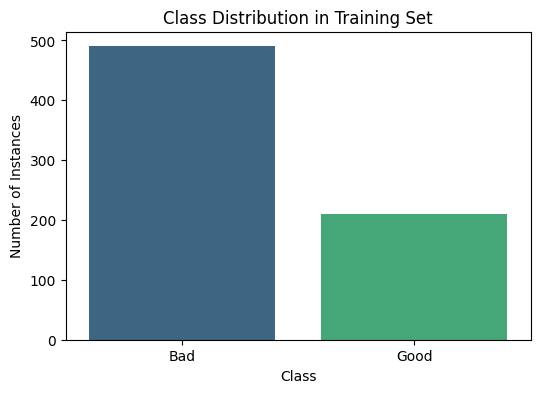

Training Set Class Distribution:
Bad: 210, Good: 490


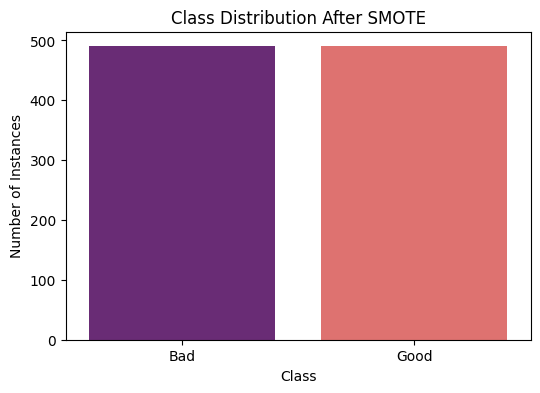

Resampled Training Set Class Distribution:
Bad: 490, Good: 490


In [15]:
# Section 3: Address Class Imbalance

# Visualize original class distribution in training set
class_counts = pd.Series(y_train).value_counts()
class_labels = ['Bad', 'Good']

plt.figure(figsize=(6,4))
sns.barplot(x=class_labels, y=class_counts.values, palette='viridis')
plt.title('Class Distribution in Training Set')
plt.ylabel('Number of Instances')
plt.xlabel('Class')
plt.show()

print(f"Training Set Class Distribution:\nBad: {class_counts.get(0,0)}, Good: {class_counts.get(1,0)}")

# Initialize SMOTE
smote = SMOTE(random_state=42, sampling_strategy='auto')  # 'auto' resamples to balance classes

# Apply SMOTE to training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Verify the new class distribution
resampled_class_counts = pd.Series(y_train_resampled).value_counts()

plt.figure(figsize=(6,4))
sns.barplot(x=class_labels, y=resampled_class_counts.values, palette='magma')
plt.title('Class Distribution After SMOTE')
plt.ylabel('Number of Instances')
plt.xlabel('Class')
plt.show()

print(f"Resampled Training Set Class Distribution:\nBad: {resampled_class_counts.get(0,0)}, Good: {resampled_class_counts.get(1,0)}")


In [17]:
# Section 4: Train and Evaluate Models on Clean Data

# Initialize the models
models = initialize_models(random_state=42)
print("Models Initialized:")
for name in models:
    print(f"- {name}")

# Train and evaluate models on resampled (balanced) data
clean_results = train_and_evaluate(models, X_train_resampled, y_train_resampled, X_val, y_val)
print("\nModel Training and Evaluation on Clean Data Completed.\n")
from sklearn.metrics import classification_report

# Display the results
for model_name, metrics in clean_results.items():
    print(f"--- {model_name} ---")
    print(f"Accuracy: {metrics['Accuracy']:.4f}")
    print(f"AUC: {metrics['AUC']:.4f}")
    print(f"F1 Score: {metrics['F1 Score']:.4f}")
    print(f"Confusion Matrix:\n{metrics['Confusion Matrix']}\n")
    
    # Detailed Classification Report
    print("Classification Report:")
    print(classification_report(y_val, metrics['Confusion Matrix'].ravel()))
    print("\n")


Models Initialized:
- XGBoost
- RandomForest

Model Training and Evaluation on Clean Data Completed.

--- XGBoost ---
Accuracy: 0.6667
AUC: 0.6868
F1 Score: 0.7727
Confusion Matrix:
[[15 30]
 [20 85]]

Classification Report:


ValueError: Found input variables with inconsistent numbers of samples: [150, 4]